# Elaborazione dei dati iniziali, esiti e grafici

Questo notebook Jupyter esegue il calcolo della circonferenza ottimale disponendo poi i punti iniziali. 
Definito l'intervallo entro il quale rappresentare il relativo grafico si propone la curva della somma dei quadrati degli scarti.

@author: lorenzo

In [1]:
from scipy import optimize
import numpy as np
from math import sqrt, pi
import matplotlib.pyplot as plt

In [2]:
def calc_R(x, y, xc, yc):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f(c, x, y):
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()

def least_squares_circle(coords):
    x, y = None, None
    if isinstance(coords, np.ndarray):
        x = coords[:, 0]
        y = coords[:, 1]
    elif isinstance(coords, list):
        x = np.array([point[0] for point in coords])
        y = np.array([point[1] for point in coords])
    else:
        raise Exception(
            "Il parametro 'coords' è di un tipo non supportato: " + str(type(coords)))

    # coordinate del baricentro
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center, _ = optimize.leastsq(f, center_estimate, args = (x, y))
    xc, yc = center
    Ri = calc_R(x, y, *center)
    R = Ri.mean()
    residui = np.sum((Ri - R)**2)
    return xc, yc, R, residui

In [3]:
# Genera il poligono regolare geometrico
def poligonoRegolare(alfa, pars):
    xPolMobile = []
    yPolMobile = []
    for n in pars[5]:
        xPolMobile.append(pars[0] + pars[2]*np.cos(n*(2*pi/pars[6])+alfa+0.2))
        yPolMobile.append(pars[1] + pars[2]*np.sin(n*(2*pi/pars[6])+alfa+0.2))
    return xPolMobile, yPolMobile

In [4]:
def sommaQuad(alfa, pars):
    dim = len(alfa)
    verticiUtilizzati = len(pars[5])
    xPolMobile, yPolMobile = poligonoRegolare(alfa, pars)
    difxq = (np.broadcast_to(pars[3],(dim,verticiUtilizzati)) - np.transpose(xPolMobile))**2
    difyq = (np.broadcast_to(pars[4],(dim,verticiUtilizzati)) - np.transpose(yPolMobile))**2
    somma = sum(np.transpose(difxq + difyq))
    return somma

In [5]:
def individuaNAN(x):
    return np.where(np.isnan(x))

In [6]:
def plot_data_circle(x, y, xc, yc, R):
    """
    Plot i dati e la circonferenza ottimale.
    Inputs:
        x : dati, x values (array)
        y : dati, y values (array)
        xc : ascissa del centro 
        yc : ordinata del centro
        R : raggio della circonferenza ottimale

    Output:
        None (genera un plot matplotlib).
    """
    f = plt.figure(facecolor = 'white')
    plt.axis('equal')

    theta_fit = np.linspace(-pi, pi, 180)

    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    plt.plot(x_fit, y_fit, 'b-', label = " circonferenza ottimale", lw = 2)
    plt.plot([xc], [yc], 'bD', mec = 'y', mew = 1)
    plt.xlabel('x')
    plt.ylabel('y')
    # plot i dati
    plt.scatter(x, y, c = 'red', label = 'dati')

    plt.legend(loc = 'best', labelspacing = 0.1)
    plt.grid()
    plt.title('Circonferenza ottimale')

Viene letto il file CSV nel quale sono presenti i dati iniziali.

In [7]:
data = np.loadtxt("datiOrdinatiInt.csv", delimiter = ",")

Nella cella sottostante vengono eseguite le elaborazioni numeriche (i commenti forniscono dei sintetici significati)

In [8]:
xdata = data[:, 0]
ydata = data[:, 1]

numLati = len(xdata)
indiceN = np.arange(0, numLati, 1)  
#costruisco le terne ciascuna delle quali esprime [indice, xdato, ydato]
terne=np.transpose(np.array([indiceN, xdata, ydata]))
# indici di dove compaiono elementi non numerici NaN
indiciNAN = individuaNAN(terne)
# elimina le terne contenenenti una o piu' NaN
terne = np.delete(terne, indiciNAN[0], 0)
# riassegna i dati effettivi 
[indiciEffettivi, xdata, ydata] = np.transpose(terne)

coords = np.transpose([xdata, ydata])
xc, yc, r, s = least_squares_circle(coords)
par = [xc, yc, r, xdata, ydata, indiciEffettivi, numLati]

Le istruzioni successive forniscono a video gli esiti e le informazioni sulla procedura di ricerca del minimo della funzione sommaQuad. Il termine fun fornisce il valore del minimo della funzione mentre l'ultimo (x) l'angolo in corrispondenza del quale lo si ottiene. per individuare il minimo della funzione *sommaQuad* tale valore dev'essere compreso tra gli estremi dell'intervallo 

In [9]:
print('----------+++-----------')
print('ascissaCentro = ',xc,'  ordinataCentro = ',yc,'  raggio = ',r)
print('----------+++-----------')
diz = optimize.minimize(sommaQuad, 0, (par))
print(diz)
print('----------+++-----------')

----------+++-----------
ascissaCentro =  34.96123480743832   ordinataCentro =  -0.9728377110489871   raggio =  9.681332768676825
----------+++-----------
      fun: 0.002370174153330864
 hess_inv: array([[0.00088911]])
      jac: array([-3.16678779e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.15944277])
----------+++-----------


Vengono rappresentate la circonferenza ottimale e i punti iniziali effettivi (non il poligono ottimale) e il grafico della funzione *sommaQuad* nell'intervallo eventualmente scelto nell'istruzione successiva.

In [10]:
#definire gli estremi dell'intervallo tra i quali calcolare 100 valori di sommaQuad: inizialmente sono 0.1 e 0.2 per i due ottagoni.
theta = np.linspace(0.1, 0.2, 100)

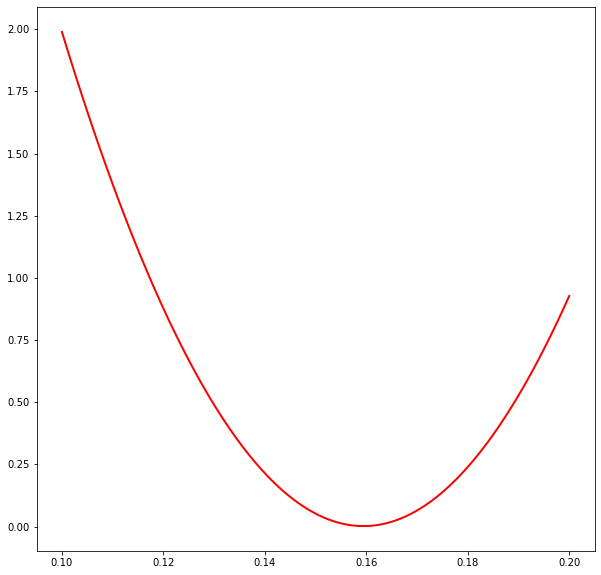

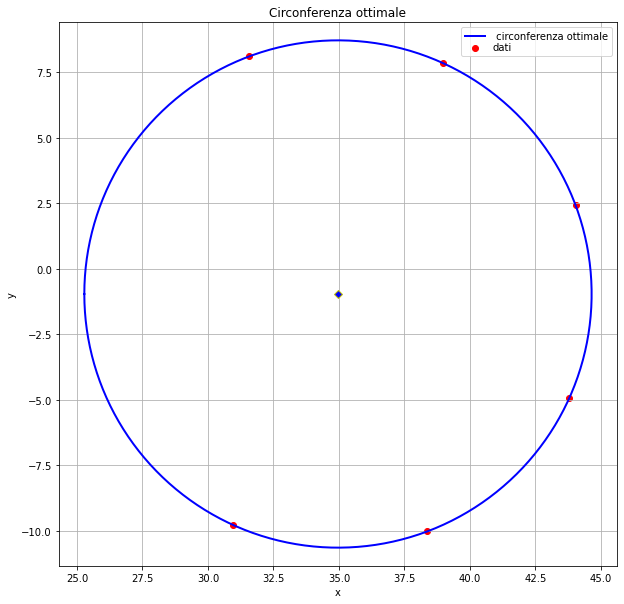

In [11]:
# grafico della circonferenza ottimale e dei punti iniziali
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(theta, sommaQuad(theta, par), color ='red', lw = 2)
plot_data_circle(xdata, ydata, xc, yc, r)
plt.show()